In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.callbacks import ModelCheckpoint

## Functions

---


In [2]:
#Removes column of class labels from dataframe and saves into new array
def features_labels_split(data, label_column):
    features = data.copy()
    columns_titles = list(data.columns)
    features = features.reindex(columns=columns_titles)
    labels = features.pop(label_column)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels


#Plots training/validation accuracy and loss. Can optionally print the numerical values.
def plot_train_val(model_history, title_acc, title_loss, path_acc, path_loss, metrics=True):
    train_acc = np.array(model_history.history["accuracy"])
    train_loss = np.array(model_history.history["loss"])

    val_loss = np.array(model_history.history["val_loss"])
    val_acc = np.array(model_history.history["val_accuracy"])

    epochs = np.arange(train_loss.shape[0])
    plt.figure(figsize=(10,5)) 
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label = "Training")
    plt.plot(epochs, val_loss, label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title_acc)
    plt.legend()
    plt.savefig(path_acc, bbox_inches="tight") 

    plt.figure(figsize=(10,5)) 
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label = "Training")
    plt.plot(epochs, val_acc, label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title_loss)
    plt.legend()
    plt.savefig(path_loss, bbox_inches="tight") 

    train_score = [train_acc[-1], train_loss[-1]]
    val_score = [val_acc[-1], val_loss[-1]]

    if metrics == True:
        print(f"\nTraining accuracy: {round(train_score[0], 5) * 100}%")
        print(f"Training loss: {round(train_score[1], 4)}")
        print(f"\nValidation accuracy: {round(val_score[0], 5) * 100}%")
        print(f"Validation loss: {round(val_score[1], 4)}")

## Load Data

---

In [3]:
data = np.load('data/data.npz', allow_pickle=True)

x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_val = data['x_val']
y_val = data['y_val']


print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)

x_train shape:  (1922, 165)
y_train shape:  (1922, 2)
x_test shape:  (412, 165)
y_test shape:  (412, 2)
x_val shape:  (413, 165)
y_val shape:  (413, 2)


## ANN Model


*'DEEP-INTRUSION DETECTION SYSTEM WITH ENHANCED UNSW-NB15 DATASET BASED ON DEEP LEARNING TECHNIQUES', A.M. ALEESA, MOHAMMED YOUNIS, AHMED A. MOHAMMED, NAN M. SAHAR*


---

<img src='img/models/ann.png'>

In [4]:
#Define
model = Sequential()

model.add(Dense(input_dim=x_train.shape[1], units=850, activation='relu')) #input & hidden layer 1
model.add(Dense(units=2, activation='softmax')) #output/prediction layer

model.summary() #display model architecture information

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 850)               141100    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1702      
Total params: 142,802
Trainable params: 142,802
Non-trainable params: 0
_________________________________________________________________


In [5]:
#Compile
model.compile(loss="binary_crossentropy",  #they did not specify loss function, assume binary cross entropy
        optimizer=Adam(learning_rate=0.001), #they did not specify learning rate, placeholder value for now
        metrics=["accuracy"])

In [6]:
#Best model callback
model_path = 'trained_models/ann'
checkpoint = ModelCheckpoint(
    filepath=model_path, 
    monitor='val_loss', #save model based on best validation loss
    verbose=0, 
    save_best_only=True,
    mode='min')
callbacks = [checkpoint]

In [7]:
#Fit
start = time()
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    epochs=100,
    batch_size=100,
    verbose=1 
)


print(f'Complete. \nModel trained in {round(time()-start, 2)} sec')

Epoch 1/100
20/20 [==============================] - 9s 18ms/step - loss: 0.6030 - accuracy: 0.6896 - val_loss: 0.4098 - val_accuracy: 0.8160
INFO:tensorflow:Assets written to: trained_models/ann/assets
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.8462 - val_loss: 0.2164 - val_accuracy: 0.9588
INFO:tensorflow:Assets written to: trained_models/ann/assets
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1853 - accuracy: 0.9590 - val_loss: 0.1061 - val_accuracy: 0.9782
INFO:tensorflow:Assets written to: trained_models/ann/assets
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0997 - accuracy: 0.9887 - val_loss: 0.0556 - val_accuracy: 0.9976
INFO:tensorflow:Assets written to: trained_models/ann/assets
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.9970 - val_loss: 0.0326 - val_accuracy: 0.9976
INFO:tensorflow:Assets written to: trained_models/


Training accuracy: 100.0%
Training loss: 0.0

Validation accuracy: 100.0%
Validation loss: 0.0003


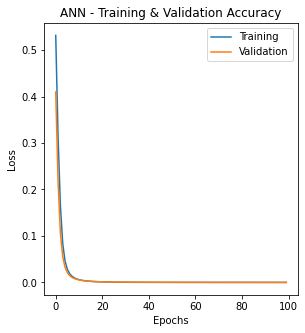

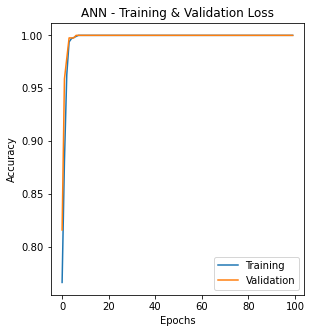

In [8]:
title_loss = 'ANN - Training & Validation Loss'
title_acc = 'ANN - Training & Validation Accuracy'
path_loss = 'img/models/ann_loss'
path_acc = 'img/models/ann_acc'

plot_train_val(history, title_acc=title_acc, title_loss=title_loss, path_acc=path_acc, path_loss=path_loss)

## Evaluation Metrics
---

In [9]:
y_pred = np.argmax(model.predict(x_test), axis=-1) 
y_true = np.argmax(y_test, axis=-1) 

acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision  = precision_score(y_true, y_pred, average='weighted')
f1  = f1_score(y_true, y_pred, average='weighted')
auc  = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')

print('Accuracy: ', acc)
print('Precision: ', recall)
print('Recall: ', precision)
print('F1-score: ', f1)
print('AUC: ', auc)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-score:  1.0
AUC:  1.0


## Confusion Matrix

---

In [10]:
font = {'size': 16}
labels = ['Normal', 'DoS']

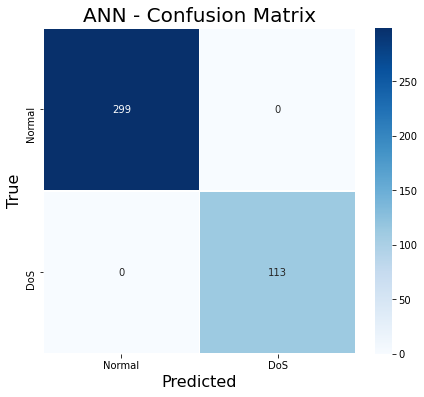

In [11]:
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(confusion, annot=True, linewidths=0.8, xticklabels=labels, yticklabels=labels, fmt='d', cmap='Blues')
plt.title(f'ANN - Confusion Matrix', fontsize=20) 
plt.xlabel('Predicted', fontdict=font)
plt.ylabel('True', fontdict=font)

plt.savefig('img/models/ann_cm', bbox_inches="tight") 